Generating nail to thread dictionary: 0/27
Generating nail to thread dictionary: 10/27
Generating nail to thread dictionary: 20/27
Thread 0 of 324
Generating nail to thread dictionary: 0/36
Generating nail to thread dictionary: 10/36
Generating nail to thread dictionary: 20/36
Generating nail to thread dictionary: 30/36
Thread 0 of 448
Input image


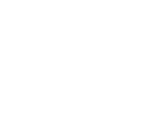

All nails on elipse


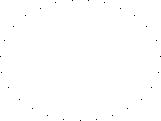

All nails on rectangle


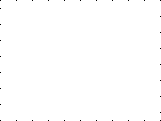

First nail of elipse


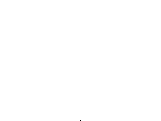

First nail of rectangle


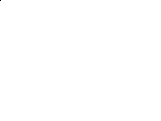

Nail from get_other_end_of_thread of first thread of elipse


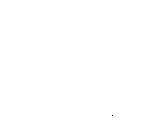

Nail from get_other_end_of_thread of first thread of rectangle


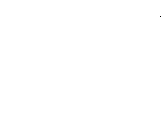

Threads from get_threads_from_nail of first nail of elipse


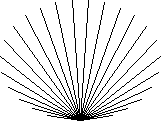

Threads from get_threads_from_nail of first nail of rectangle


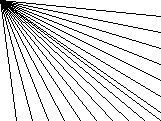

Threads from dictionary of first nail of elipse


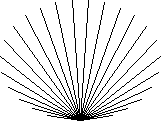

Threads from dictionary of first nail of rectangle


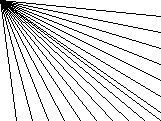

Points from dictionary of first thread of elipse


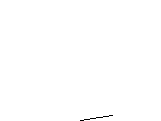

Points from dictionary of first thread of rectangle


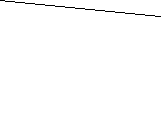

In [7]:

from skimage.draw import line
from PIL import Image

import matplotlib.pyplot as plt
import numpy as np
import cv2
import pickle
import scipy as sp
import scipy.optimize

NAIL_DISTANCE = 16

def display_image(image):
    display(Image.fromarray(image))
    
def display_nails(nails, image):
    canvas = np.ones(image.shape, np.uint8) * 255
    for nail in nails:
        canvas[nail[0], nail[1]] = 0
    display_image(canvas)

def display_threads(lines, image):
    canvas = np.ones(image.shape, np.uint8) * 255
    for line in lines:
        canvas = cv2.line(canvas, (line[0][1], line[0][0]), (line[1][1], line[1][0]), 0, 1)
    display_image(canvas)

def generate_nail_positions(dimensions, nail_arrangement):
    nails = []
    if nail_arrangement == "ellipse":
        flip = False
        if dimensions[0] < dimensions[1]:
            a = dimensions[0] - 0.5
            b = dimensions[1] - 0.5
            flip = True
        else:
            a = dimensions[1] - 0.5
            b = dimensions[0] - 0.5

        elipse_circumference = np.pi * (3/2 * (a/2 + b/2) - np.sqrt((a/2) * (b/2)))
        num = int(elipse_circumference / NAIL_DISTANCE)

        angles = 2 * np.pi * np.arange(num) / num
        if a != b:
            e2 = (1.0 - a ** 2.0 / b ** 2.0)
            tot_size = sp.special.ellipeinc(2.0 * np.pi, e2)
            arc_size = tot_size / num
            arcs = np.arange(num) * arc_size
            res = sp.optimize.root(
                lambda x: (sp.special.ellipeinc(x, e2) - arcs), angles)
            angles = res.x 
    
        for angle in angles:
            if flip:
                nails.append(np.array([int((a * np.cos(angle))/2 + a/2), int((b * np.sin(angle))/2 + b/2)]))
            else:
                nails.append(np.array([int((b * np.sin(angle))/2 + b/2), int((a * np.cos(angle))/2 + a/2)]))

    elif nail_arrangement == "rectangle":

        r0, c0 = 0, 0
        r1, c1, = 0, dimensions[1] - 1
        r2, c2 = dimensions[0] - 1, dimensions[1] - 1
        r3, c3 = dimensions[0] - 1, 0

        for i in range(c0, c1, NAIL_DISTANCE):
            nails.append((c0, i))

        for i in range(r1, r2, NAIL_DISTANCE):
            nails.append((i, c1))

        for i in range(c2, c3, -NAIL_DISTANCE):
            nails.append((r2, i))
            
        for i in range(r3, r0, -NAIL_DISTANCE):
            nails.append((i, c3))

    return np.array(nails)



def is_on_same_edge(point1, point2, dimensions):
    if point1[0] == 0 and point2[0] == 0:
        return True
    if point1[0] == dimensions[0] - 1 and point2[0] == dimensions[0] - 1:
        return True
    if point1[1] == 0 and point2[1] == 0:
        return True
    if point1[1] == dimensions[1] - 1 and point2[1] == dimensions[1] - 1:
        return True
    return False

def generate_thread_positions(nails, dimensions, nail_arrangement):
    threads = []
    if nail_arrangement == "ellipse":
        SKIP_NEIGHBOUR_NAILS = 1
        for i in range(0, len(nails)):
            for j in range(i + 1 + SKIP_NEIGHBOUR_NAILS, len(nails)):
                if i == 0 and j >= len(nails) - SKIP_NEIGHBOUR_NAILS: continue # Skip the last nails in first iteration
                threads.append(np.array([nails[i], nails[j]]))
    elif nail_arrangement == "rectangle":
        for i in range(0, len(nails)):
            for j in range(i, len(nails)):
                if not is_on_same_edge(nails[i], nails[j], dimensions):
                    threads.append(np.array([nails[i], nails[j]]))
    return np.array(threads)

def get_other_end_of_thread(thread, nail):
    if np.array_equal(thread[0], nail):
        return thread[1]
    return thread[0]

def get_threads_from_nail(threads, nail):
    threads_from_nail = []
    for thread in threads:
        if np.array_equal(thread[0], nail) or np.array_equal(thread[1], nail):
            threads_from_nail.append(thread)
    return np.array(threads_from_nail)    

def generate_nail_to_threads_dictionary(nails, threads):
    nail_to_thread_dictionary = {}
    it = 0
    for nail in nails:
        if it%10 == 0:
            print("Generating nail to thread dictionary: " + str(it) + "/" + str(len(nails)))
        nail_to_thread_dictionary[nail.tobytes()] = get_threads_from_nail(threads, nail)
        it += 1
    return nail_to_thread_dictionary

def generate_thread_to_points_dictionary(threads):
    thread_to_points_dictionary = {}
    it = 0
    for thread in threads:
        if it%1000 == 0:
            print("Thread " + str(it) + " of " + str(len(threads)))
        it += 1
        a, b = line(thread[0][0], thread[0][1], thread[1][0], thread[1][1])
        points = []
        for i in range(len(a)):
            points.append((a[i], b[i]))
        thread_to_points_dictionary[thread.tobytes()] = np.array(points)
    return thread_to_points_dictionary


# #
# # Test 
# #

test_image = np.ones((121, 161), np.uint8) * 255

nails_e = generate_nail_positions(test_image.shape, "ellipse")
threads_e = generate_thread_positions(nails_e, test_image.shape, "ellipse")

nails_r = generate_nail_positions(test_image.shape, "rectangle")
threads_r = generate_thread_positions(nails_r, test_image.shape, "rectangle")

nail_to_threads_dictionary_e = generate_nail_to_threads_dictionary(nails_e, threads_e)
thread_to_points_dictionary_e = generate_thread_to_points_dictionary(threads_e)

nail_to_threads_dictionary_r = generate_nail_to_threads_dictionary(nails_r, threads_r)
thread_to_points_dictionary_r = generate_thread_to_points_dictionary(threads_r)

print("Input image")
display_image(test_image)

print("All nails on elipse")
display_nails(nails_e, test_image)
print("All nails on rectangle")
display_nails(nails_r, test_image)

print("First nail of elipse")
display_nails([nails_e[0]], test_image)
print("First nail of rectangle")
display_nails([nails_r[0]], test_image)

print("Nail from get_other_end_of_thread of first thread of elipse")
display_nails([get_other_end_of_thread(threads_e[0], nails_e[0])], test_image)
print("Nail from get_other_end_of_thread of first thread of rectangle")
display_nails([get_other_end_of_thread(threads_r[0], nails_r[0])], test_image)

print("Threads from get_threads_from_nail of first nail of elipse")
display_threads(get_threads_from_nail(threads_e, nails_e[0]), test_image)
print("Threads from get_threads_from_nail of first nail of rectangle")
display_threads(get_threads_from_nail(threads_r, nails_r[0]), test_image)

print("Threads from dictionary of first nail of elipse")
display_threads(nail_to_threads_dictionary_e[nails_e[0].tobytes()], test_image)
print("Threads from dictionary of first nail of rectangle")
display_threads(nail_to_threads_dictionary_r[nails_r[0].tobytes()], test_image)

print("Points from dictionary of first thread of elipse")
display_nails(thread_to_points_dictionary_e[threads_e[0].tobytes()], test_image)
print("Points from dictionary of first thread of rectangle")
display_nails(thread_to_points_dictionary_r[threads_r[0].tobytes()], test_image)


In [8]:
def pickle_dictionaries(dimensions, filename, nail_arrangement):

    nails = generate_nail_positions(dimensions, nail_arrangement)
    threads = generate_thread_positions(nails, dimensions, nail_arrangement)
    nail_to_threads_dictionary = generate_nail_to_threads_dictionary(nails, threads)
    thread_to_points_dictionary = generate_thread_to_points_dictionary(threads)

    with open("dictionaries/" + nail_arrangement + "_" + filename + "_ntt.dat", "wb") as ntt, \
            open("dictionaries/" + nail_arrangement + "_" + filename + "_ttp.dat", "wb") as ttp:
        pickle.dump(nail_to_threads_dictionary, ntt)
        pickle.dump(thread_to_points_dictionary, ttp)

# pickle_dictionaries((1561, 1561), "1x1", "ellipse")
# pickle_dictionaries((1561, 1561), "1x1", "rectangle")

# pickle_dictionaries((1761, 1321), "4x3", "ellipse")
# pickle_dictionaries((1761, 1321), "4x3", "rectangle")

# pickle_dictionaries((1801, 1441), "5x4", "ellipse")
# pickle_dictionaries((1801, 1441), "5x4", "rectangle")

# NAIL_DISTANCE = 4
# pickle_dictionaries((241, 241), "s1x1", "ellipse")


NAIL_DISTANCE = 2
pickle_dictionaries((18, 18), "test", "ellipse")

Generating nail to thread dictionary: 0/27
Generating nail to thread dictionary: 10/27
Generating nail to thread dictionary: 20/27
Thread 0 of 324
